# Интернет-магазин "Стримчик"

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Проанализируем характеристики игр и зависимости между ними для того, чтобы составить рекомендацию для потенциально прибыльной и популярной игры. Для исследования первым делом обработаем данные (приведем к общепринятому виду, рассомтрим пропуски и дубликаты). 

## Обработка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn 
from scipy import stats as st

In [3]:
try:
    data = pd.read_csv('C:/Users/klimatutti/Downloads/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


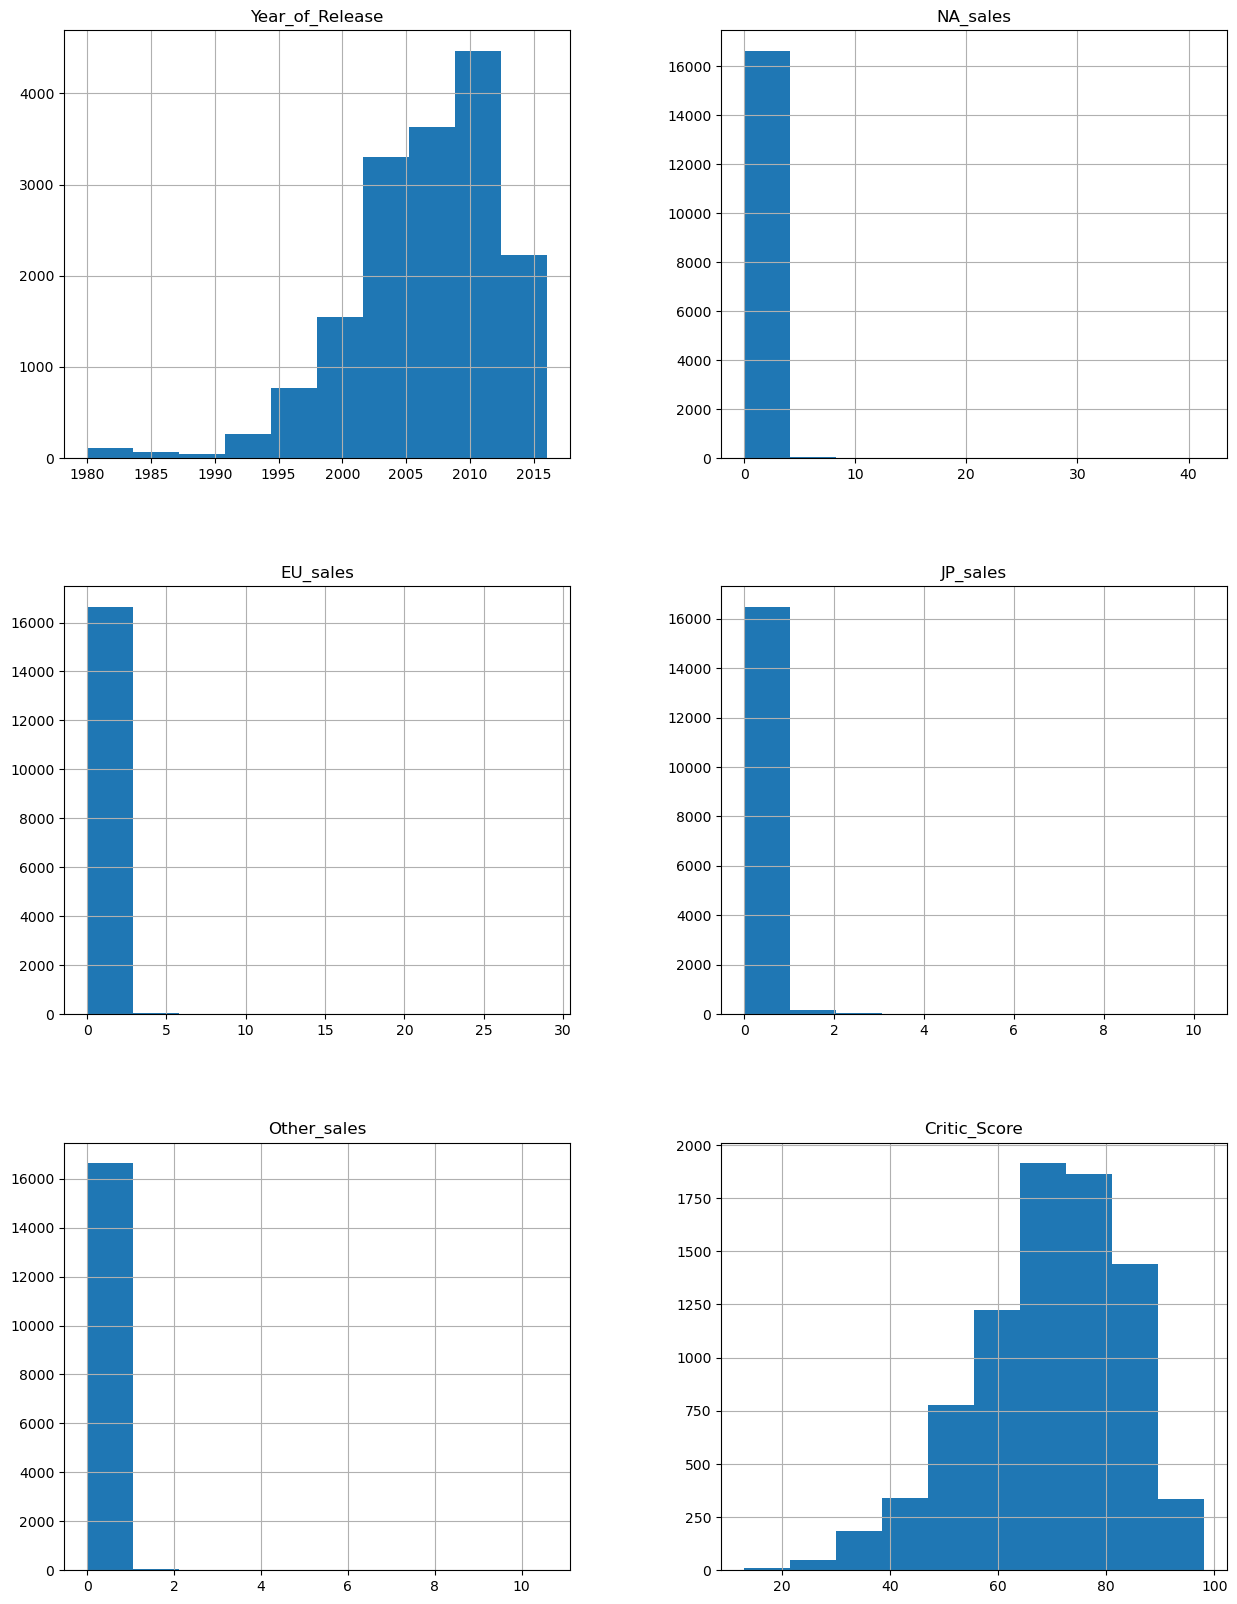

In [6]:
data.hist(figsize=(15, 20));

**Первое, что бросается в глаза:**
- Названия столбцов в верхнем регистре
- Некорректные типы данных (`Year_of_Release`, `User_Score`)
- Пропуски в некоторых стобцах

Приведем названия всех столбцов к нижнему регистру

In [7]:
data.columns = [i.lower() for i in data.columns]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим на пропуски.

In [9]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [10]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Первый столбец с пропусками - `name`.

In [11]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В этих же строках оказались пропуски в столбце `genre`, `critic_score`, `user_score`, `rating`

Таких строк всего 2. Удалим их.

In [12]:
data = data.dropna(subset=['name'])

Следующий столбец `year_of_release`

In [13]:
data.loc[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


**Пропусков здесь всего 1%, поэтому удалим их.**

In [14]:
data = data.dropna(subset=['year_of_release'])

Следующий столбец с пропусками `critic_score`

In [15]:
data.loc[data['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


**Пропуски убирать не будем, так как их почти половина от общего количества, данные могут исказить дальнейший анализ.**

Следующий столбец пропусками - `user_score`

In [16]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В уникальных значениях столбца видим `tbd`, что означает *To be determined* (будет определено позже)

Такую аббревиатуру заменить нулями некорректно, так как есть такая оценка, как 0. Пропуски в данном столбце убирать не будем по той же причине, но аббревиатуру заменим на `nan`

In [17]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [18]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

От аббревиатуры избавились.

Далее столбец `rating`

In [19]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [20]:
data.loc[data['rating'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [21]:
data.loc[data['rating'].isna(), 'rating'] = 'Unknown'
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

Заменили пропуски в столбце `rating` на *Unknown*

**Добавим новый столбец `sum_sales` - сумму всех продаж**

In [22]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [23]:
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,Unknown,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,Unknown,28.31


**Изменим типы данных**

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           16444 non-null  object 
 11  sum_sales        16444 non-null  float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB


`year_of_release` - год выпуска может быть только целым цислом.

In [25]:
data['year_of_release'] = pd.array(data['year_of_release'], dtype=pd.Int64Dtype())

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           16444 non-null  object 
 11  sum_sales        16444 non-null  float64
dtypes: Int64(1), float64(6), object(5)
memory usage: 1.6+ MB


Далее `user_score`. Оценка пользователей - числовой тип данных.

In [27]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  sum_sales        16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


## Дубликаты

In [29]:
data.duplicated().sum()

0

Явных дубликатов в датасете не обнаружено.

## Исследовательский анализ данных

**Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**

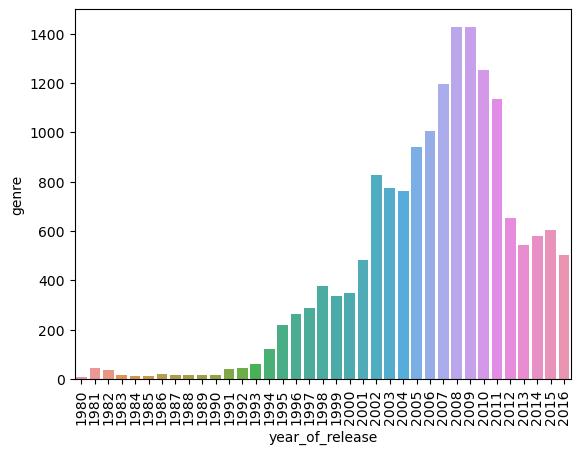

In [30]:
a = data.pivot_table(index='year_of_release', values='genre', aggfunc=len)
b = seaborn.barplot(x=a.index, y=a['genre'])
b.set_xticklabels(b.get_xticklabels(),rotation = 90);

Раньше 1995 года выходило меньше 200 игр в год. Из-за малого количества записей за этот период данные неважны.

**Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?**

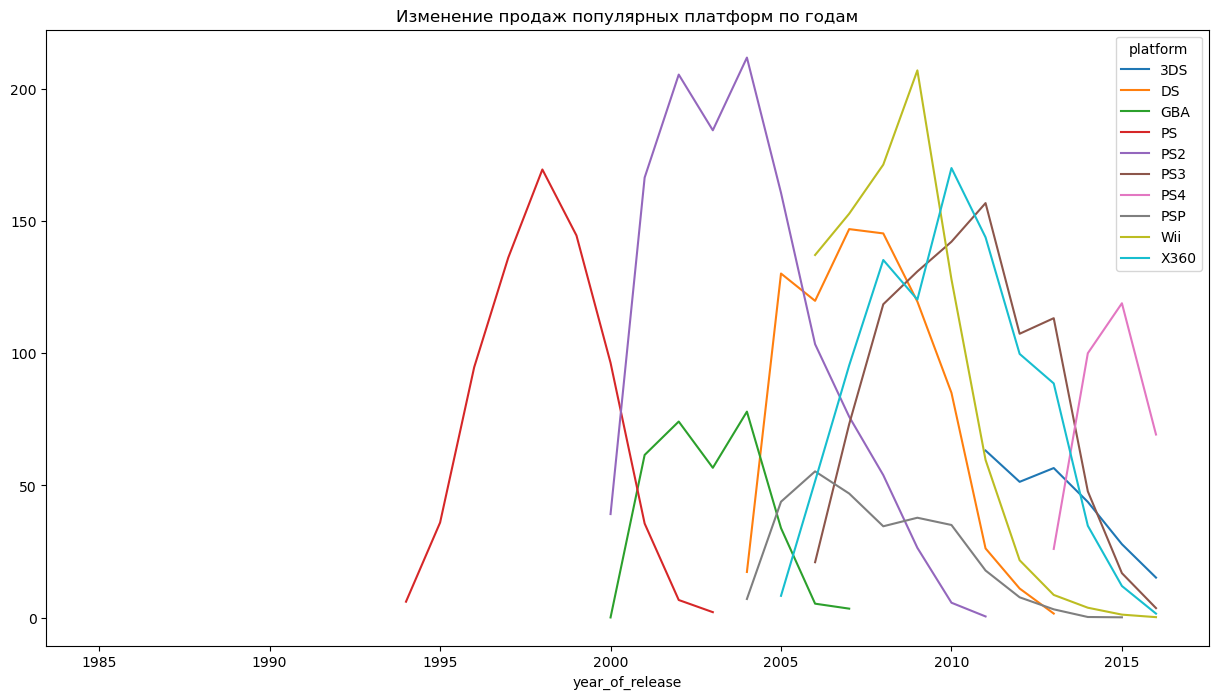

In [31]:
max_sales_platform = data.pivot_table(index=['platform'], values='sum_sales', aggfunc='sum').sort_values(by='sum_sales').tail(10).index.tolist()
max_sales_platform_data = data.query('platform == @max_sales_platform')
max_sales_platform_data_table = max_sales_platform_data.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
max_sales_platform_data_table.plot(figsize=(15,8), title='Изменение продаж популярных платформ по годам');

Такая платформа, как PS, при умемньшении продаж выпускала свою новую версию. В настоящее время существует платформа PS3, постепенно уменьшающаяся по продажам и PS4.  

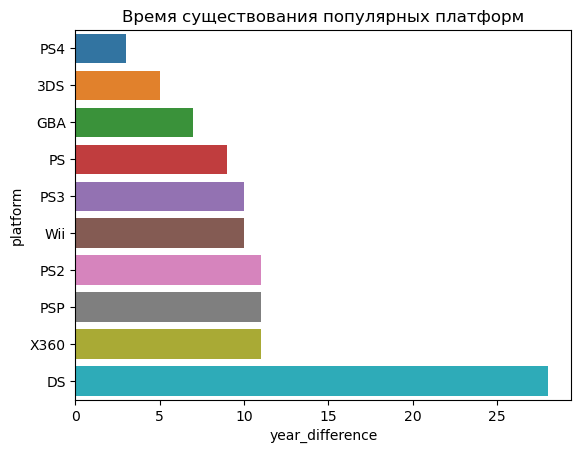

In [32]:
max_year = max_sales_platform_data.pivot_table(index='platform', values='year_of_release', aggfunc='max')
min_year = max_sales_platform_data.pivot_table(index='platform', values='year_of_release', aggfunc='min')
max_year['year_difference'] = max_year['year_of_release'] - min_year['year_of_release']
max_year = max_year.sort_values(by='year_difference')
seaborn.barplot(x=max_year['year_difference'], y=max_year.index).set_title('Время существования популярных платформ');

Выше показано время существования платформы. Самые "старая" платформа - DS. Видим, что самый маленький срок у платформы PS4, так как она появилась совсем недавно. 

**Возьмем данные за соответствующий актуальный период.**

Актуальным периодом будем считать данные с 2014 по 2016 год. Так как с начала этого периода появились платформы, которые до сих пор не исчезли, а данные за 2016 год не полные. 

**Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.**

In [33]:
period = data.loc[(data['year_of_release'] >= 2014) & (data['year_of_release'] <= 2016)]
period_sales = period.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales')
period_sales

,sum_sales
platform,
PSP,0.36
Wii,5.07
PSV,22.40
PC,27.05
WiiU,42.98
X360,48.22
PS3,68.18
3DS,86.68
XOne,140.36


Судя по таблице, лидерами продаж являются: DS, Wii, PS3, X360, но не будем забывать про время их существования. 

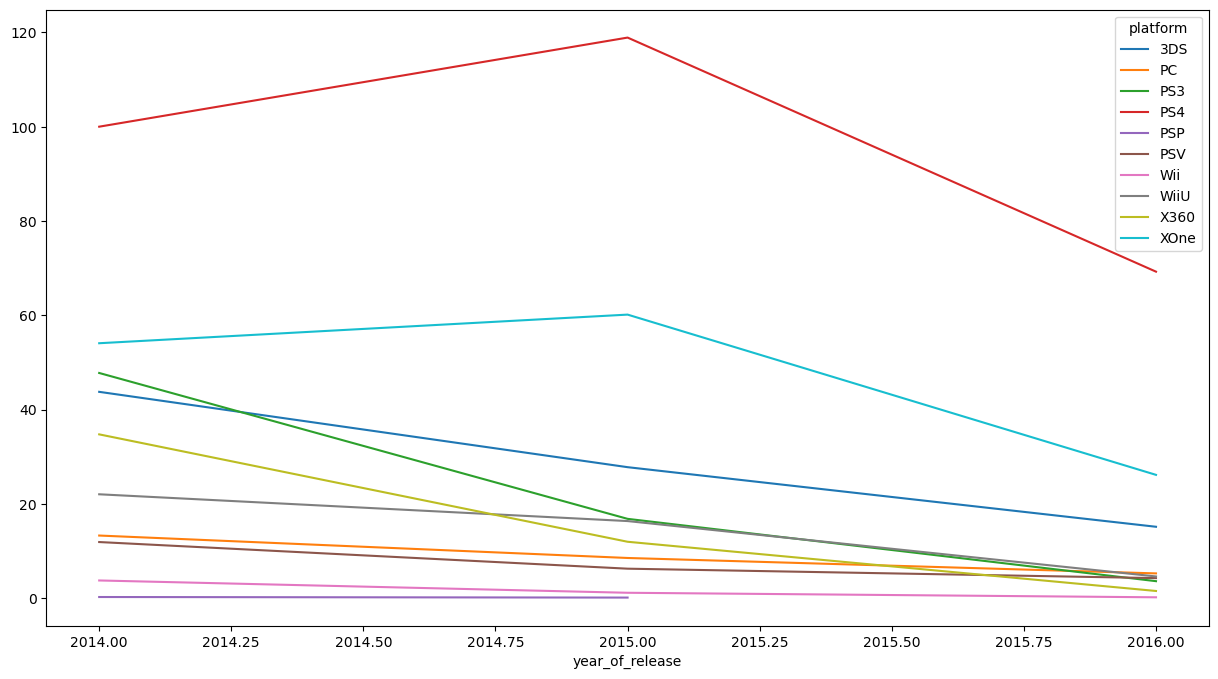

In [34]:
period.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum').plot(figsize=(15,8));

Можем заметить, что к 2015 году продажи всех платформ значительно снизились, причиной тому - выход новых двух платформ: PS4 и XOne, число продаж которых с 2013 года резко выросло. Актульным лидером продаж является PS4.

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

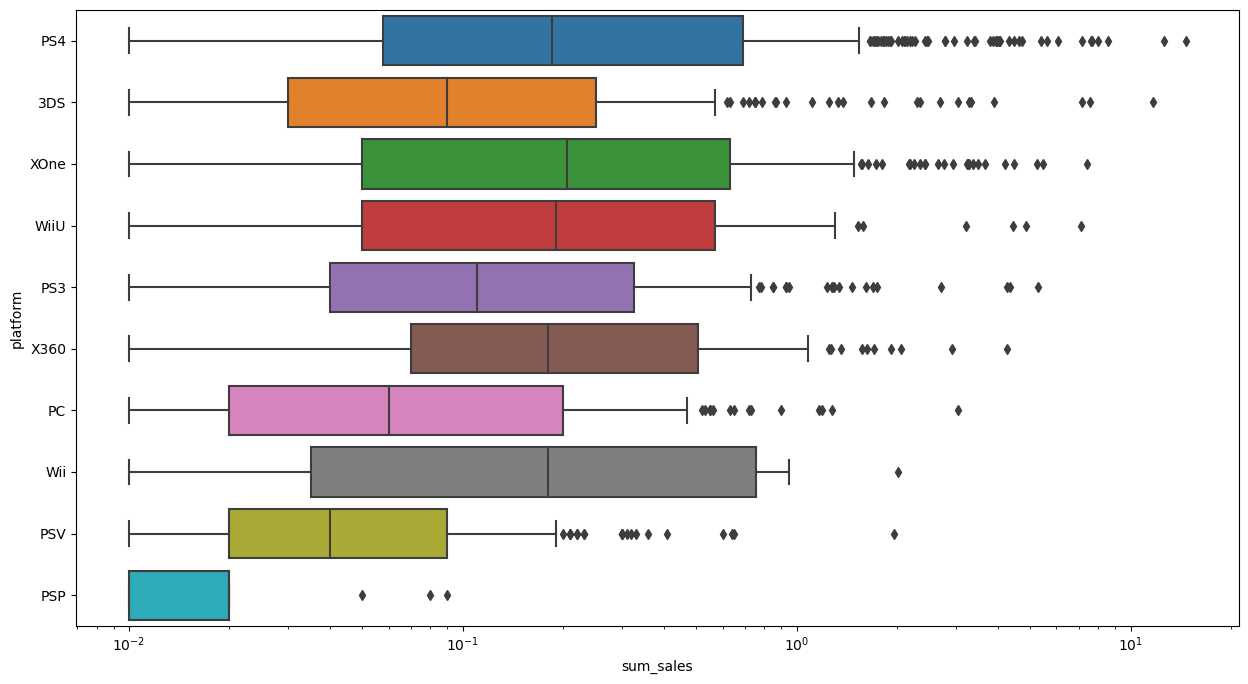

In [35]:
plt.figure(figsize=(15,8))
ax = seaborn.boxplot(y='platform', x='sum_sales', data=period);
ax.set_xscale('log')

Максимальную продажу имеют платформы PS4 и 3DS, но по медианным значениям лидирует: XOne. 

**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.**

Исходя из предыдущих рассуждений, самой популярной платформой является PS4, так как при небольшом сроке существования она находится практически наравне по продажам со старыми платформами.

In [36]:
ps4 = period.loc[period['platform'] == 'PS4']
print('Корреляция составила:', ps4['user_score'].corr(ps4['sum_sales']))

Корреляция составила: -0.040131589472697286


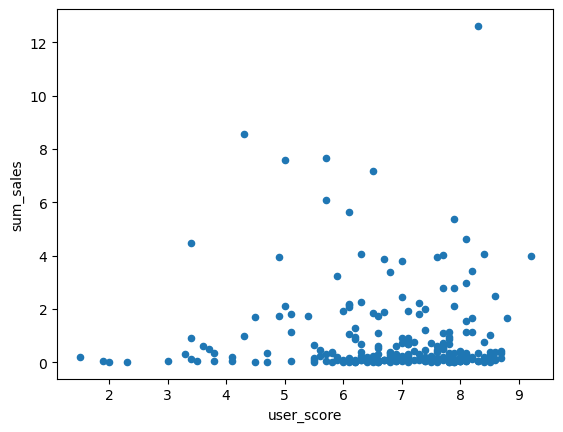

In [37]:
ps4.plot.scatter(x='user_score', y='sum_sales');

Зависимости между оценками пользователей и суммарными продажами нет.

In [38]:
print('Корреляция составила:', ps4['critic_score'].corr(ps4['sum_sales']))

Корреляция составила: 0.40266141068104083


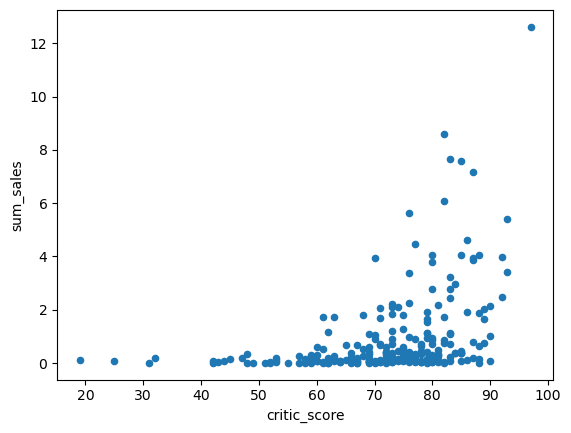

In [39]:
ps4.plot.scatter(x='critic_score', y='sum_sales');

А вот небольшая зависимость между оценками пользователей и суммарными продажами есть.

**Посмотрим графики и корреляцию для других платформ.**

Рассмотрим зависимости суммарных продаж и оценок пользователей на платформах 3DS, XOne.

In [41]:
ds = period.loc[period['platform'] == '3DS']
print('Корреляция  для платформы 3DS составила:', ds['user_score'].corr(ds['sum_sales']))

Корреляция  для платформы 3DS составила: 0.2151932718527028


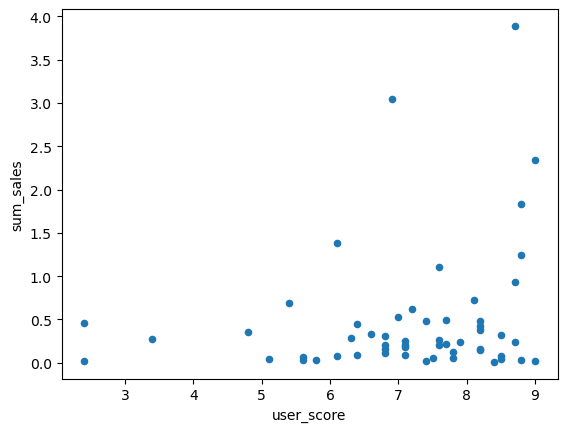

In [42]:
ds.plot.scatter(x='user_score', y='sum_sales');

In [44]:
xone = period.loc[period['platform'] == 'XOne']
print('Корреляция для платформы XOne составила:', xone['user_score'].corr(xone['sum_sales']))

Корреляция для платформы XOne составила: -0.07038392806475818


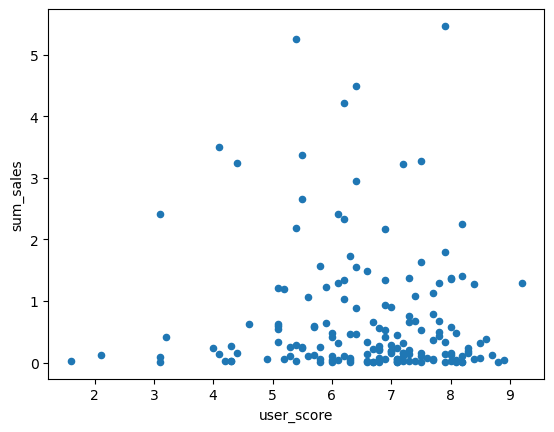

In [46]:
xone.plot.scatter(x='user_score', y='sum_sales');

**Тоже самое. Оценки пользователей практически не влияют на суммарные продажи.**

Проделаем тоже с оценками критиков.

In [47]:
print('Корреляция для платформы 3DS составила:', ds['critic_score'].corr(ds['sum_sales']))

Корреляция для платформы 3DS составила: 0.3141174928690509


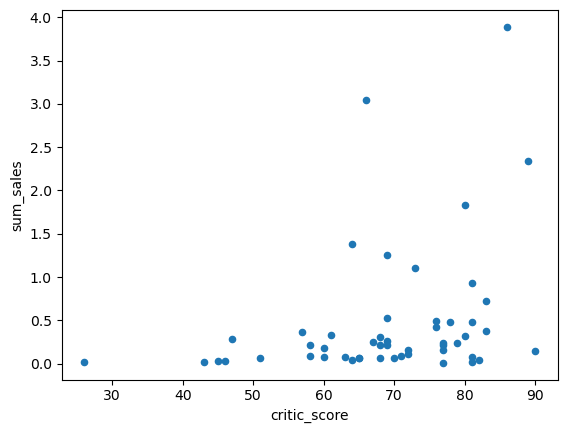

In [48]:
ds.plot.scatter(x='critic_score', y='sum_sales');

In [49]:
print('Корреляция для платформы XOne составила:', xone['critic_score'].corr(xone['sum_sales']))

Корреляция для платформы XOne составила: 0.428676943703332


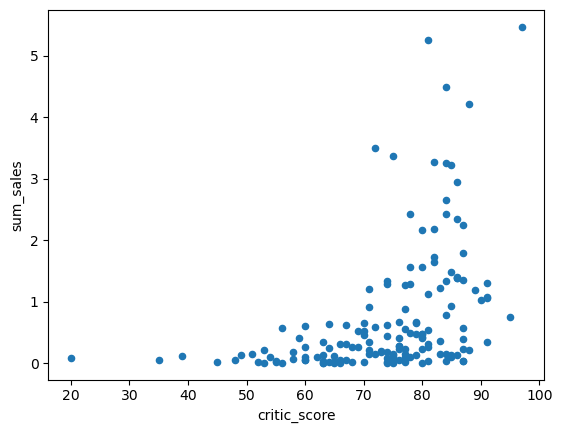

In [50]:
xone.plot.scatter(x='critic_score', y='sum_sales');

**Вывод подтвердился и для этих платформ. Небольшая зависимость между суммарными продажами и оценками критиков есть.**

**Посмотрим на общее распределение игр по жанрам.**

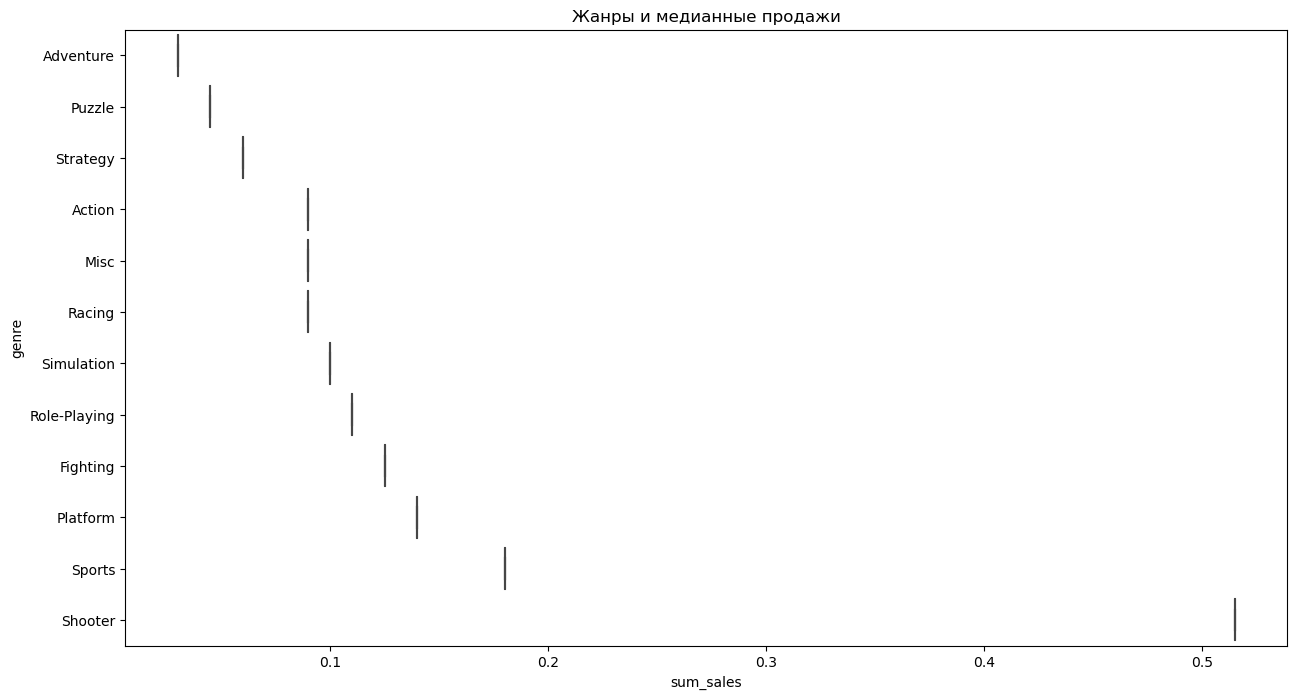

In [51]:
plt.figure(figsize=(15,8))
genre_sales = period.pivot_table(index='genre', values='sum_sales', aggfunc='median').sort_values(by='sum_sales')
seaborn.boxplot(x=genre_sales['sum_sales'], y=genre_sales.index).set_title('Жанры и медианные продажи');

Заметнее всего выделяются лидеры продаж - игры с жанром *Shooter*.

На графике мы можем выделяются еще две группы: 
- жанры с низкими продажами (Strategy, Puzzle, Adventure)
- жанры со средними продажами (Platform, Fighting, Racing, Action, Role-Playing, Misc, Sports, Simulation)

## Портрет пользователя

Определим для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). 
- Самые популярные жанры (топ-5).
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Начнем изучать популярные платформы в каждом регионе.**

Создадим сводную таблицу с топ-5 платформами по продажам в Северной Америке, а также добавим столбец с процентами продаж от общего числа.

In [52]:
na_user = period.pivot_table(index='platform', values=['na_sales', 'sum_sales'], aggfunc='sum').sort_values(by='na_sales').tail(5)

In [53]:
na_user['percent'] = round(na_user['na_sales']/na_user['sum_sales']*100)

In [54]:
na_user

,na_sales,sum_sales,percent
platform,,,
PS3,22.05,68.18,32.0
3DS,22.64,86.68,26.0
X360,28.30,48.22,59.0
XOne,81.27,140.36,58.0
PS4,98.61,288.15,34.0


В Северной Америке лидируют следующие платформы:
- PS3 (32% от общего числа продаж)
- 3DS (26% от общего числа продаж)
- X360 (59% от общего числа продаж)
- XOne (58% от общего числа продаж)
- PS4 (34% от общего числа продаж)

Создадим сводную таблицу с топ-5 платформами по продажам в Европе, а также добавим столбец с процентами продаж от общего числа.

In [55]:
eu_user = period.pivot_table(index='platform', values=['eu_sales', 'sum_sales'], aggfunc='sum').sort_values(by='eu_sales').tail(5)

In [56]:
eu_user['percent'] = round(eu_user['eu_sales']/eu_user['sum_sales']*100)

In [57]:
eu_user

,eu_sales,sum_sales,percent
platform,,,
3DS,16.12,86.68,19.0
PC,17.97,27.05,66.0
PS3,25.54,68.18,37.0
XOne,46.25,140.36,33.0
PS4,130.04,288.15,45.0


В Европе лидируют следующие платформы:
- 3DS (19% от общего числа продаж)
- PC (66% от общего числа продаж)
- PS3 (37% от общего числа продаж)
- XOne (33% от общего числа продаж)
- PS4 (45% от общего числа продаж)

Создадим сводную таблицу с топ-5 платформами по продажам в Японии, а также добавим столбец с процентами продаж от общего числа.

In [58]:
jp_user = period.pivot_table(index='platform', values=['jp_sales', 'sum_sales'], aggfunc='sum').sort_values(by='jp_sales').tail(5)

In [59]:
jp_user['percent'] = round(jp_user['jp_sales']/jp_user['sum_sales']*100)

In [60]:
jp_user

,jp_sales,sum_sales,percent
platform,,,
WiiU,7.31,42.98,17.0
PS3,11.22,68.18,16.0
PSV,14.54,22.40,65.0
PS4,15.02,288.15,5.0
3DS,44.24,86.68,51.0


В Японии лидируют следующие платформы:
- WiiU (17% от общего числа продаж)
- PS3 (16% от общего числа продаж)
- PSV (65% от общего числа продаж)
- PS4 (5% от общего числа продаж)
- 3DS (51% от общего числа продаж)

**Пользователи Северной Америки в большинстве предпочитают платформы XOne, X360.**

**Европейские пользователи чаще покупают игры на платформы PC, PS4.**

**В Японии предпочитают платформу PSV.**

Общими платформами для всех регионов оказались: PS3, PS4, 3DS.

**Проделаем тоже самое с жанрами.**

Создадим сводную таблицу с топ-5 жанрами по продажам в Северной Америке, а также добавим столбец с процентами продаж от общего числа.

In [61]:
na_genre = period.pivot_table(index='genre', values=['na_sales', 'sum_sales'], aggfunc='sum').sort_values(by='na_sales').tail(5)

In [62]:
na_genre['percent'] = round(na_genre['na_sales']/na_genre['sum_sales']*100)
na_genre

,na_sales,sum_sales,percent
genre,,,
Misc,15.05,37.55,40.0
Role-Playing,33.47,101.44,33.0
Sports,46.13,109.48,42.0
Action,72.53,199.36,36.0
Shooter,79.02,170.94,46.0


В Северной Америке лидируют следующие жанры:
- Role-Playing (33% от общего числа продаж)
- Misc (40% от общего числа продаж)
- Shooter (46% от общего числа продаж)
- Sports (42% от общего числа продаж)
- Action (36% от общего числа продаж)

Создадим сводную таблицу с топ-5 жанрами по продажам в Европе, а также добавим столбец с процентами продаж от общего числа.

In [63]:
eu_genre = period.pivot_table(index='genre', values=['eu_sales', 'sum_sales'], aggfunc='sum').sort_values(by='eu_sales').tail(5)

In [64]:
eu_genre['percent'] = round(eu_genre['eu_sales']/eu_genre['sum_sales']*100)
eu_genre

,eu_sales,sum_sales,percent
genre,,,
Racing,14.13,27.52,51.0
Role-Playing,28.17,101.44,28.0
Sports,45.73,109.48,42.0
Shooter,65.52,170.94,38.0
Action,74.68,199.36,37.0


В Европе лидируют следующие жанры:
- Role-Playing (28% от общего числа продаж)
- Racing (51% от общего числа продаж)
- Shooter (38% от общего числа продаж)
- Sports (42% от общего числа продаж)
- Action (37% от общего числа продаж)

Создадим сводную таблицу с топ-5 жанрами по продажам в Японии, а также добавим столбец с процентами продаж от общего числа.

In [65]:
jp_genre = period.pivot_table(index='genre', values=['jp_sales', 'sum_sales'], aggfunc='sum').sort_values(by='jp_sales').tail(5)

In [66]:
jp_genre['percent'] = round(jp_genre['jp_sales']/jp_genre['sum_sales']*100)
jp_genre

,jp_sales,sum_sales,percent
genre,,,
Shooter,4.87,170.94,3.0
Misc,5.61,37.55,15.0
Fighting,6.37,28.22,23.0
Action,29.58,199.36,15.0
Role-Playing,31.16,101.44,31.0


В Японии лидируют следующие жанры:
- Shooter (3% от общего числа продаж)
- Fighting (23% от общего числа продаж)
- Misc (15% от общего числа продаж)
- Action (15% от общего числа продаж)
- Role-Playing (31% от общего числа продаж)

**Пользователи всех регионов играют в игры с жанрами: Action, Role-Playing, Shooter.**

**Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

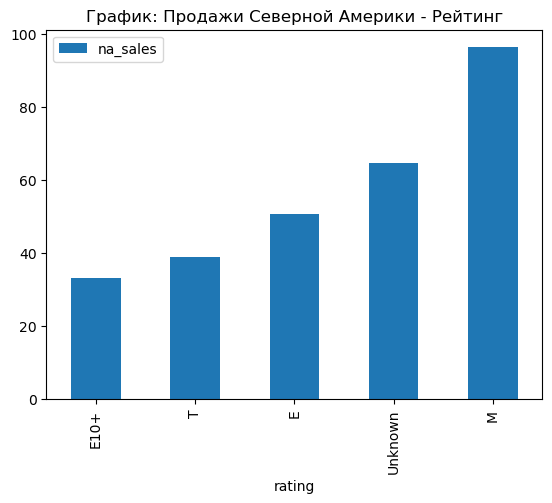

In [70]:
period.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales').plot(kind='bar', title='График: Продажи Северной Америки - Рейтинг');

Лидером продаж в Северной Америке является рейтинг *M - От 17 лет*. Также покупают игры с рейтингами: Е - Для всех, E10+ - От 10 лет, T - Для взрослых и неизвестный рейтинг.

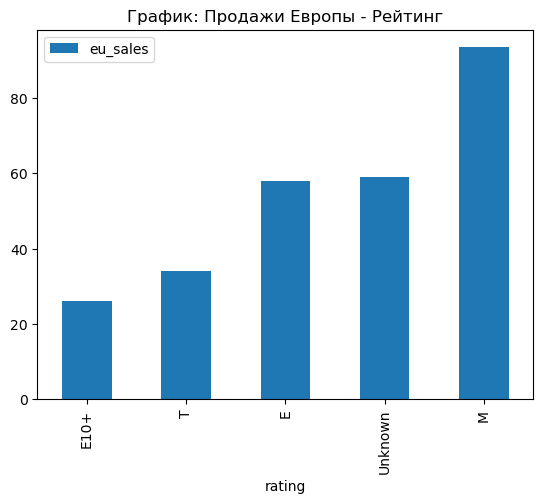

In [71]:
period.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales').plot(kind='bar', title='График: Продажи Европы - Рейтинг');

Ситуация с рейтигами в Европе практически такая же, как в Северной Америке.

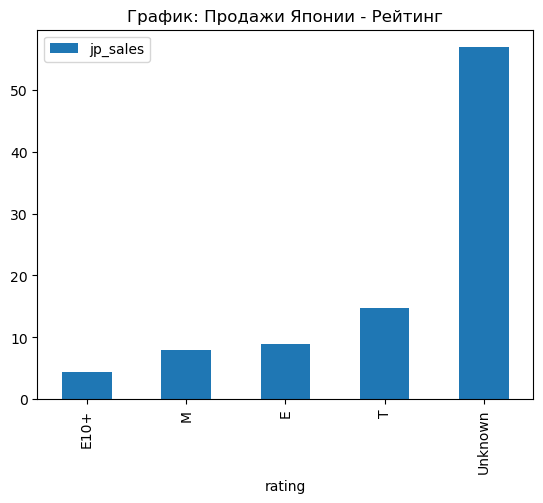

In [72]:
period.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales').plot(kind='bar', title='График: Продажи Японии - Рейтинг');

В Японии большего всего игр с неизвестным (пропущенным) рейтингом. Также покупают игры с ретингами: E, E10+, M, T.

## Проверка гипотез

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Из данного высказывания следует нулевая гипотеза: Средние пользовательские рейтинги платформы XOne = средним пользовательским рейтингам платформы PC.

Альтернативная гипотеза: Средние пользовательские рейтинги платформы XOne ≠ средним пользовательским рейтингам платформы PC.

In [73]:
results = st.ttest_ind(
    period.loc[(period['platform'] == 'XOne') & (~period['user_score'].isna()), 'user_score'], 
    period.loc[(period['platform'] == 'PC') & (~period['user_score'].isna()), 'user_score'])

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


**Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

Нулевая гипотеза: Средние пользовательские рейтинги жанра Action = средним пользовательским рейтингам жанра Sports
    
Альтернативная гипотеза: Средние пользовательские рейтинги жанра Action ≠ средним пользовательским рейтингам жанра Sports

In [74]:
results = st.ttest_ind(
    period.loc[(period['genre'] == 'Action') & (~period['user_score'].isna()), 'user_score'], 
    period.loc[(period['genre'] == 'Sports') & (~period['user_score'].isna()), 'user_score'])

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.8711147985105864e-19
Отвергаем нулевую гипотезу


## Вывод

In [75]:
sum(data['na_sales'])/sum(data['sum_sales'])

0.4925388882018682

**Почти 50% игр были проданы пользователям Северной Америки**

**Скачки продаж обусловлены появлением новых платформ**

За последний период активно набирают популярность недавно появившиеся платформы PS4 и XOne.

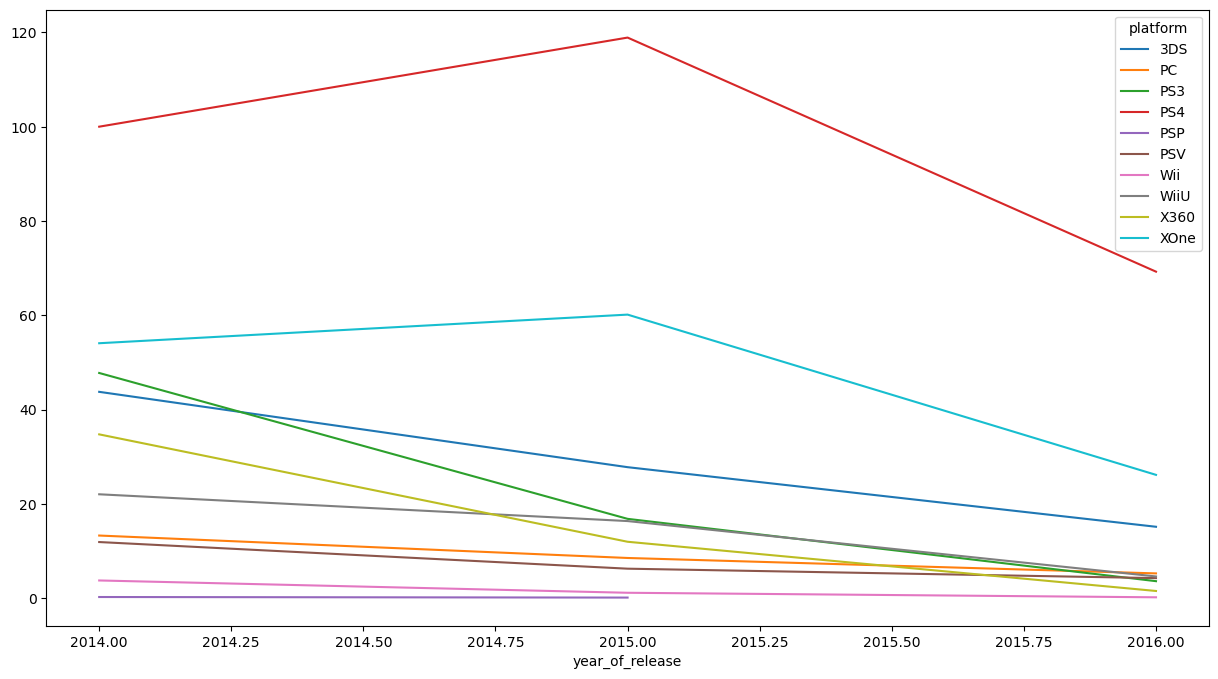

Максимальную продажу имеют платформы PS4 и 3DS, но по медианным значениям лидирует: XOne. 

**Было определено, что на количество продаж оценки критиков влияют больше, чем оценки пользователей.**

Самым популярным жанром является **Shooter**

**Пользователи Северной Америки в большинстве предпочитают платформы XOne, X360.**

**Европейские пользователи чаще покупают игры на платформы PC, PS4.**

**В Японии предпочитают платформу PSV.**

Общими платформами для всех регионов оказались: PS3, PS4, 3DS.

**Предпочтения пользователей Северной Америки и Европы схожи, но пользователи Японии предпочитают немного иные платформы и жанры.**

Из-за того, что рейтинги устанавливаются для США и Канады, у игр, проданных в Японии, преобладает неизвестный (пропущенный) рейтинг. 

В Северной Америке и Европе преобладает рейтинг M - от 17 лет.

Не смотря на популярность только что вышедших платформ PS4 и XOne, платформы: PS3, PS4, 3DS используются во всех регионах.

Примерные характеристики игры, которая пользуется популярностью:

    Платформы: PS3, PS4, 3DS.
    Жанр: Shooter
    Рейтинг: M